<a href="https://colab.research.google.com/github/sunmyeonglee/2025-1-NLP/blob/main/2_named_entity_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Named Entity Recognition
- For a given word and its context window, estimate whether the given word is location or not

## Introduction to Named Entity Recognition (NER)

Named Entity Recognition is a subtask of Natural Language Processing (NLP) that focuses on identifying and categorizing named entities in text. Named entities are real-world objects such as people, organizations, locations, dates, etc. that can be denoted with a proper name.

In this notebook, we'll focus on a binary classification task: determining whether a word represents an organization or not based on its surrounding context.

We'll go through the following steps:
1. Download and explore the CoNLL2003 dataset
2. Preprocess the data and create context windows
3. Convert words to vectors using pre-trained word embeddings
4. Build and train a neural network classifier
5. Evaluate the model on test data
6. Use the model for inference

# 1. Download dataset
- CoNLL2003

The CoNLL2003 dataset is a widely used benchmark for NER tasks. It contains news articles with manually annotated named entities. Each word is labeled with its entity type (if any): person (PER), location (LOC), organization (ORG), or miscellaneous (MISC).

Let's download the dataset and extract it.

In [2]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 850.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 15.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [1]:
!wget https://data.deepai.org/conll2003.zip # Download dataset
!unzip conll2003.zip # Unzip dataset zip

--2025-04-15 04:53:02--  https://data.deepai.org/conll2003.zip
Resolving data.deepai.org (data.deepai.org)... 143.244.49.179, 2400:52e0:1a01::900:1
Connecting to data.deepai.org (data.deepai.org)|143.244.49.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 982975 (960K) [application/zip]
Saving to: ‘conll2003.zip.1’

conll2003.zip.1     100%[===================>] 959.94K  5.49MB/s    in 0.2s    

2025-04-15 04:53:02 (5.49 MB/s) - ‘conll2003.zip.1’ saved [982975/982975]

Archive:  conll2003.zip
replace metadata? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace test.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace train.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace valid.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


## 2. Preprocess Dataset

Now that we have the dataset, let's first take a look at its structure. Each line in the dataset contains a word followed by its part-of-speech tag, syntactic chunk tag, and named entity tag. We'll focus on the words and their named entity tags.

In [2]:
with open("train.txt") as f:
  string = ''.join(f.readlines())
dataset = string.split('\n')

dataset[:70]  # Display the first 70 lines of the dataset

['-DOCSTART- -X- -X- O',
 '',
 'EU NNP B-NP B-ORG',
 'rejects VBZ B-VP O',
 'German JJ B-NP B-MISC',
 'call NN I-NP O',
 'to TO B-VP O',
 'boycott VB I-VP O',
 'British JJ B-NP B-MISC',
 'lamb NN I-NP O',
 '. . O O',
 '',
 'Peter NNP B-NP B-PER',
 'Blackburn NNP I-NP I-PER',
 '',
 'BRUSSELS NNP B-NP B-LOC',
 '1996-08-22 CD I-NP O',
 '',
 'The DT B-NP O',
 'European NNP I-NP B-ORG',
 'Commission NNP I-NP I-ORG',
 'said VBD B-VP O',
 'on IN B-PP O',
 'Thursday NNP B-NP O',
 'it PRP B-NP O',
 'disagreed VBD B-VP O',
 'with IN B-PP O',
 'German JJ B-NP B-MISC',
 'advice NN I-NP O',
 'to TO B-PP O',
 'consumers NNS B-NP O',
 'to TO B-VP O',
 'shun VB I-VP O',
 'British JJ B-NP B-MISC',
 'lamb NN I-NP O',
 'until IN B-SBAR O',
 'scientists NNS B-NP O',
 'determine VBP B-VP O',
 'whether IN B-SBAR O',
 'mad JJ B-NP O',
 'cow NN I-NP O',
 'disease NN I-NP O',
 'can MD B-VP O',
 'be VB I-VP O',
 'transmitted VBN I-VP O',
 'to TO B-PP O',
 'sheep NN B-NP O',
 '. . O O',
 '',
 'Germany NNP B-NP B

### 2.1 Organizing Text into Sentences

The dataset contains sentences separated by empty lines. We'll group the words into sentences to maintain the context for each word. The `groupby` function from `itertools` helps us split the data based on empty lines.

In [3]:
from itertools import groupby

dataset_in_sentence = [list(group) for k, group in groupby(dataset, lambda x: x == "") if not k]
dataset_in_sentence[:5]  # Display the first 5 sentences

[['-DOCSTART- -X- -X- O'],
 ['EU NNP B-NP B-ORG',
  'rejects VBZ B-VP O',
  'German JJ B-NP B-MISC',
  'call NN I-NP O',
  'to TO B-VP O',
  'boycott VB I-VP O',
  'British JJ B-NP B-MISC',
  'lamb NN I-NP O',
  '. . O O'],
 ['Peter NNP B-NP B-PER', 'Blackburn NNP I-NP I-PER'],
 ['BRUSSELS NNP B-NP B-LOC', '1996-08-22 CD I-NP O'],
 ['The DT B-NP O',
  'European NNP I-NP B-ORG',
  'Commission NNP I-NP I-ORG',
  'said VBD B-VP O',
  'on IN B-PP O',
  'Thursday NNP B-NP O',
  'it PRP B-NP O',
  'disagreed VBD B-VP O',
  'with IN B-PP O',
  'German JJ B-NP B-MISC',
  'advice NN I-NP O',
  'to TO B-PP O',
  'consumers NNS B-NP O',
  'to TO B-VP O',
  'shun VB I-VP O',
  'British JJ B-NP B-MISC',
  'lamb NN I-NP O',
  'until IN B-SBAR O',
  'scientists NNS B-NP O',
  'determine VBP B-VP O',
  'whether IN B-SBAR O',
  'mad JJ B-NP O',
  'cow NN I-NP O',
  'disease NN I-NP O',
  'can MD B-VP O',
  'be VB I-VP O',
  'transmitted VBN I-VP O',
  'to TO B-PP O',
  'sheep NN B-NP O',
  '. . O O']]

### 2.2 Filtering Short Sentences

Some sentences in the dataset might be too short for our context window approach. Let's filter out sentences that have fewer than 6 words.

In [4]:
# Filter out sentences that are too short for our context window approach
filtered_dataset = [sentence for sentence in dataset_in_sentence if len(sentence) > 5]
len(filtered_dataset)  # Number of sentences after filtering

10625

In [5]:
# Check an example sentence
filtered_dataset[1000]

['" " O O',
 'I PRP B-NP O',
 'think VBP B-VP O',
 'this DT B-NP O',
 'is VBZ B-VP O',
 'a DT B-NP O',
 'bad JJ I-NP O',
 'beginning NN I-NP O',
 '. . O O']

### 2.3 Creating Context Windows

For each word in a sentence, we'll create a context window that includes the target word and its surrounding words. This context will help our model determine whether a word represents an organization.

Let's define a window length and see how the context window looks for each word in a sentence.

In [6]:
window_len = 2  # Number of words to consider on each side of the target word
sentence = filtered_dataset[0]  # Example sentence

for i, word in enumerate(sentence):
  print(f'word is {word}')
  splitted_word = word.split(' ')
  print(f'splitted_word is {splitted_word}')
  center_word = splitted_word[0]        # The actual word
  label = splitted_word[-1]             # The entity tag (O, B-ORG, I-ORG, etc.)
  print(center_word, label)
  is_organization = label in ['B-ORG', 'I-ORG']  # Binary label: is this an organization?
  print(f"is organization: {is_organization}")

  # Collecting words to the left of the target word
  prev_index = max(i - window_len, 0)  # Prevent negative indices
  prev_words = sentence[prev_index:i]
  prev_words = [word_str.split(' ')[0] for word_str in prev_words]  # Extract just the words

  # Collecting words to the right of the target word
  next_index = i + window_len + 1
  next_words = sentence[i+1:next_index]
  next_words = [word_str.split(' ')[0] for word_str in next_words]

  print(f"prev_words is {prev_words}")
  print(f"next_words is {next_words}")

  # Add padding if there aren't enough words on either side
  if len(prev_words) != window_len:
    prev_words = ['<pad>'] * (window_len - len(prev_words)) + prev_words

  if len(next_words) != window_len:
    next_words = next_words + ['<pad>'] * (window_len - len(next_words))

  # The final context window: previous words + target word + next words
  concatenated_words = prev_words + [center_word] + next_words
  print(f"concatenated_words is {concatenated_words}")
  print("--------------------------------")

word is EU NNP B-NP B-ORG
splitted_word is ['EU', 'NNP', 'B-NP', 'B-ORG']
EU B-ORG
is organization: True
prev_words is []
next_words is ['rejects', 'German']
concatenated_words is ['<pad>', '<pad>', 'EU', 'rejects', 'German']
--------------------------------
word is rejects VBZ B-VP O
splitted_word is ['rejects', 'VBZ', 'B-VP', 'O']
rejects O
is organization: False
prev_words is ['EU']
next_words is ['German', 'call']
concatenated_words is ['<pad>', 'EU', 'rejects', 'German', 'call']
--------------------------------
word is German JJ B-NP B-MISC
splitted_word is ['German', 'JJ', 'B-NP', 'B-MISC']
German B-MISC
is organization: False
prev_words is ['EU', 'rejects']
next_words is ['call', 'to']
concatenated_words is ['EU', 'rejects', 'German', 'call', 'to']
--------------------------------
word is call NN I-NP O
splitted_word is ['call', 'NN', 'I-NP', 'O']
call O
is organization: False
prev_words is ['rejects', 'German']
next_words is ['to', 'boycott']
concatenated_words is ['rejects', '

### 2.4 Creating Context Windows for All Sentences

Now, let's create a function to generate context windows for all words in a sentence, and apply it to our entire dataset.

In [7]:
def make_window_words_and_label_from_sentence(sentence):
  total_output = []
  for i, word in enumerate(sentence):
    splitted_word = word.split(' ')
    center_word = splitted_word[0]
    label = splitted_word[-1]
    is_organization = label in ['B-ORG', 'I-ORG']

    # Concatenating with neighboring words
    # Words to the left
    prev_index = max(i - window_len, 0)  # Clipping minimum to zero
    prev_words = sentence[prev_index:i]
    prev_words = [word_str.split(' ')[0] for word_str in prev_words]  # Collect the main word

    # Words to the right
    next_index = i + window_len + 1
    next_words = sentence[i+1:next_index]
    next_words = [word_str.split(' ')[0] for word_str in next_words]

    # Add padding if needed
    if len(prev_words) != window_len:
      prev_words = ['<pad>'] * (window_len - len(prev_words)) + prev_words

    if len(next_words) != window_len:
      next_words = next_words + ['<pad>'] * (window_len - len(next_words))

    concatenated_words = prev_words + [center_word] + next_words
    total_output.append((concatenated_words, is_organization))
  return total_output

# Test the function on our example sentence
make_window_words_and_label_from_sentence(sentence)

[(['<pad>', '<pad>', 'EU', 'rejects', 'German'], True),
 (['<pad>', 'EU', 'rejects', 'German', 'call'], False),
 (['EU', 'rejects', 'German', 'call', 'to'], False),
 (['rejects', 'German', 'call', 'to', 'boycott'], False),
 (['German', 'call', 'to', 'boycott', 'British'], False),
 (['call', 'to', 'boycott', 'British', 'lamb'], False),
 (['to', 'boycott', 'British', 'lamb', '.'], False),
 (['boycott', 'British', 'lamb', '.', '<pad>'], False),
 (['British', 'lamb', '.', '<pad>', '<pad>'], False)]

### 2.5 Processing the Entire Dataset

Now let's apply this function to all sentences in our dataset and flatten the result to get a list of (context_window, label) pairs.

In [8]:
# Process all sentences and flatten the result
entire_dataset = [make_window_words_and_label_from_sentence(sentence) for sentence in filtered_dataset]
# Flatten the nested list
entire_dataset = [windowed_word for sentence in entire_dataset for windowed_word in sentence]

In [9]:
len(entire_dataset)  # Total number of words with context windows

192587

In [10]:
entire_dataset[10000]  # Example of a (context_window, label) pair

(['eight', 'in', 'a', 'row', ','], False)

## 3. Word Embeddings

To feed our text data into a neural network, we need to convert words into numerical vectors. We'll use pre-trained GloVe word embeddings, which capture semantic relationships between words based on their co-occurrence in a large corpus.

In [11]:
import gensim.downloader

# Load pre-trained GloVe word embeddings (300-dimensional vectors)
wrd2vec = gensim.downloader.load("glove-wiki-gigaword-300")

[==================================================] 100.0% 376.1/376.1MB downloaded


In [12]:
len(wrd2vec)  # Number of words in the vocabulary

400000

### 3.1 Converting Words to Vectors

We need to convert each context window into a single feature vector. We'll do this by:
1. Converting each word in the context window to its vector representation
2. Concatenating these vectors to form a single feature vector

For words not in the GloVe vocabulary, we'll use zero vectors.

In [13]:
import numpy as np
data_example = entire_dataset[0]
word_list, label = data_example

# Function to convert a list of words into a single concatenated vector
def get_flattened_vector(word_list:list, wrd2vec):
  cat_vector = []

  for word in word_list:
    if word.lower() in wrd2vec:
      vector = wrd2vec[word.lower()]
    else:
      vector = np.zeros(300)
    cat_vector.append(vector)
  cat_vector = np.concatenate(cat_vector)
  #print(cat_vector.shape)
  return cat_vector

# Check the shape of the resulting vector (5 words x 300 dimensions = 1500)
get_flattened_vector(word_list, wrd2vec).shape

(1500,)

In [14]:
word = word_list[3]
wrd2vec[word].shape
cat_vector = []

for word in word_list:
  if word.lower() in wrd2vec:
    vector = wrd2vec[word.lower()]
  else:
    vector = np.zeros(300)
  cat_vector.append(vector)
cat_vector = np.concatenate(cat_vector)
print(cat_vector.shape)

(1500,)


## 4. Building a Neural Network Classifier

Now we'll create a simple neural network model to predict whether a word represents an organization based on its context. The model will take the concatenated word vectors as input and output a probability.

In [15]:
import torch
import torch.nn as nn

class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=1500, out_features=128)
    self.layer2 = nn.Linear(in_features=128, out_features=1)

  def forward(self, x):
    layer1output = self.layer1(x)
    layer2output = self.layer2(layer1output.relu())
    return layer2output.sigmoid()
  pass


# Test the model with a sample input
input_vec = get_flattened_vector(word_list, wrd2vec)
model = Classifier()
# model = Classifier(input_size=1500, hidden_size=47, output_size=1)
model(torch.Tensor(input_vec))



tensor([0.4965], grad_fn=<SigmoidBackward0>)

# 5. Creating a Dataset Class

To make training more efficient, we'll create a custom Dataset class that handles data loading and preprocessing.

Our custom Dataset class will:
1. Load and preprocess the CoNLL2003 dataset
2. Create context windows for each word
3. Convert words to vectors
4. Provide an interface for accessing (feature, label) pairs

This follows PyTorch's Dataset conventions, making it easy to use with DataLoader for batch processing.

In [16]:
class Dataset:
  def __init__(self, txt_fn="train.txt", wrd2vec=None, window_len=2):
    self.window_len = window_len
    text_lines = self.load_txt_and_split(txt_fn)
    dataset_in_sentence = self.group_by_sentence(text_lines)
    filtered_dataset = [sentence for sentence in dataset_in_sentence if len(sentence) > 5]
    entire_dataset = [self.make_window_words_and_label_from_sentence(sentence) for sentence in filtered_dataset]
    self.entire_data = self.flatten_list_of_list(entire_dataset)
    self.wrd2vec = wrd2vec
    # self.window_len = window_len 여기에 declare하면 함수가 먼저 읽어지니까 에러남

  @staticmethod
  def flatten_list_of_list(list_of_list): # in staticmehtod, we don't use self as an argument
    return [y for x in list_of_list for y in x]
    #  We don't use any of self.attribute or self.method() or something
    # [ [1,2,3], [5,7,8], [0,1] ] -> [1,2,3,5,7,8,0,1]


  def make_window_words_and_label_from_sentence(self, sentence):
    total_output = []
    window_len = self.window_len
    for i, word in enumerate(sentence):
      splitted_word = word.split(' ')
      center_word = splitted_word[0]
      label = splitted_word[-1]
      is_organization = label in ['B-ORG', 'I-ORG']

      # concatenating with neighboring words
      # words in the left
      prev_index = max(i - window_len, 0)  # clipping minimum to zero
      prev_words = sentence[prev_index:i]
      prev_words = [word_str.split(' ')[0] for word_str in prev_words]  # collect the main word

      # words in the right
      next_index = i + window_len + 1
      next_words = sentence[i+1:next_index]
      next_words = [word_str.split(' ')[0] for word_str in next_words]

      # Add padding if needed
      if len(prev_words) != window_len:
        prev_words = ['<pad>'] * (window_len - len(prev_words)) + prev_words

      if len(next_words) != window_len:
        next_words = next_words + ['<pad>'] * (window_len - len(next_words))

      concatenated_words = prev_words + [center_word] + next_words
      total_output.append((concatenated_words, is_organization))
    return total_output

  @staticmethod
  def group_by_sentence(text_lines:list):
    return [list(group) for k, group in groupby(text_lines, lambda x: x == "") if not k]

  @staticmethod
  def load_txt_and_split(txt_fn):
    with open(txt_fn) as f:
      string = ''.join(f.readlines())
    dataset = string.split('\n')
    return dataset

  # def _load_txt_and_split(self, txt_fn="train.txt"):
  #   with open(txt_fn) as f:
  #     string = ''.join(f.readlines())
  #   dataset = string.split('\n')
  #   return dataset

  # __getitem__ and __len__ is the most important part of the dataset
  def __getitem__(self, idx):
    # This function is called when we call dataset[idx]
    # It has to return idx-th item
    data_sample = self.entire_data[idx]
    # print(f'data_sample: {data_sample}')
    windowed_words, label = data_sample
    # print(f'windowed_words: {windowed_words}')
    flattened_vector = self.get_flattened_vector(windowed_words, self.wrd2vec)
    # print(f'flattened_vector: {flattened_vector}')
    return flattened_vector, label

  def __len__(self):
    # This function is called when we call len(dataset)
    # In dataset, we want to get the total number of data sample
    return len(self.entire_data)

  @staticmethod
  def get_flattened_vector(word_list:list, wrd2vec):
    flattened_vec = []
    for word in word_list:
      word = word.lower()
      if word in wrd2vec:
        vec = wrd2vec[word]
      else:
        vec = np.zeros(300)
      flattened_vec.append(vec)
    flattened_vec = np.concatenate(flattened_vec)
    return flattened_vec

# Create a dataset instance
dataset = Dataset(wrd2vec=wrd2vec)
print(len(dataset))
dataset[0]  # Check a sample

192587


(array([ 0.        ,  0.        ,  0.        , ..., -0.19499999,
         0.20411   ,  0.35297999]),
 True)

### 5.1 Creating a Data Loader

Now we'll create a data loader that will efficiently batch our data for training. We need a custom collate function to handle our data format.

In [17]:
from typing import List, Tuple
from torch.utils.data import DataLoader

def custom_collate_fn(raw_batch:List[Tuple[np.ndarray, bool]]):
  vector = [vector for vector, label in raw_batch]
  label = [label for vector, label in raw_batch]
  return torch.tensor(vector).float(), torch.tensor(label).float()
  # add torch.tensor(vector).float() since Error: mat1 and mat2 must have the same dtype, but got Double and Float


# Create a data loader
train_loader = DataLoader(dataset, batch_size=32, collate_fn=custom_collate_fn, shuffle=True) # Adding 'shuffle=True', you can get random index.

# Test our custom collate function
raw_batch = [dataset[i] for i in range(3)]  # This is how DataLoader calls its dataset
custom_collate_fn(raw_batch)  # And it feeds this raw_batch to collate_fn

<ipython-input-17-c01f41fc495f>:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  return torch.tensor(vector).float(), torch.tensor(label).float()


(tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.1950,  0.2041,  0.3530],
         [ 0.0000,  0.0000,  0.0000,  ..., -0.2705, -0.1292, -0.0133],
         [ 0.5473, -0.2364, -0.2143,  ..., -0.1604,  0.0467, -0.0706]]),
 tensor([1., 0., 0.]))

In [18]:
for batch in train_loader:
  print(batch)
  break

(tensor([[-0.2117,  0.1462,  0.0605,  ..., -0.3422, -0.0224,  0.1368],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.1301,  0.3195,  0.0234],
        [-0.0892,  0.9644, -0.0840,  ..., -1.2129,  0.7766,  0.1933],
        ...,
        [-0.2687,  0.0124, -0.0439,  ...,  0.1396, -1.1386, -0.4506],
        [-0.4116,  0.0194,  0.2853,  ..., -0.7578,  0.3193, -0.1188],
        [ 0.3241,  0.1680, -0.2468,  ...,  0.0000,  0.0000,  0.0000]]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))


## 6. Training the Model

Before training, we need to define a loss function. We'll use Binary Cross-Entropy (BCE) loss, which is appropriate for binary classification.

In [19]:
def get_bce(pred, target, eps=1e-4):
  loss =  -(target * torch.log(pred + eps) + (1 - target) * torch.log(1 - pred + eps))
  return loss.mean()

In [20]:
print(batch)
vector, label = batch
model = Classifier()
pred = model(vector)
pred = pred.squeeze(1) # if not, pred.shape = torch.Size([32, 1])
# pred.shape, label.shape
pred, label
loss = get_bce(pred, label)
print(loss)

(tensor([[-0.2117,  0.1462,  0.0605,  ..., -0.3422, -0.0224,  0.1368],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.1301,  0.3195,  0.0234],
        [-0.0892,  0.9644, -0.0840,  ..., -1.2129,  0.7766,  0.1933],
        ...,
        [-0.2687,  0.0124, -0.0439,  ...,  0.1396, -1.1386, -0.4506],
        [-0.4116,  0.0194,  0.2853,  ..., -0.7578,  0.3193, -0.1188],
        [ 0.3241,  0.1680, -0.2468,  ...,  0.0000,  0.0000,  0.0000]]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))
tensor(0.7245, grad_fn=<MeanBackward0>)


Now let's train our model. We'll:
1. Create the model with appropriate dimensions
2. Define an optimizer (Adam)
3. Train for multiple epochs
4. Record the loss for plotting

In [21]:
from tqdm.auto import tqdm

# Initialize model
model = Classifier()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)  # Adam optimizer
train_loader = DataLoader(dataset, batch_size=128, collate_fn=custom_collate_fn, shuffle=True)
dev = 'cuda'  # Use GPU if available

model.to(dev)  # Move model to GPU
loss_record = []  # To track progress
num_epochs = 1

for epoch in range(num_epochs):
  for batch in tqdm(train_loader, leave=False):  # Use tqdm for progress bar
    vector, label = batch
    vector = vector.to(dev)
    label = label.to(dev)
    pred = model(vector).squeeze() # add squeeze
    loss = get_bce(pred, label)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_record.append(loss.item())

  0%|          | 0/1505 [00:00<?, ?it/s]

### 6.1 Visualizing Training Progress

Let's plot the loss over time to see how our training progressed.

Text(0, 0.5, 'Binary Cross-Entropy Loss')

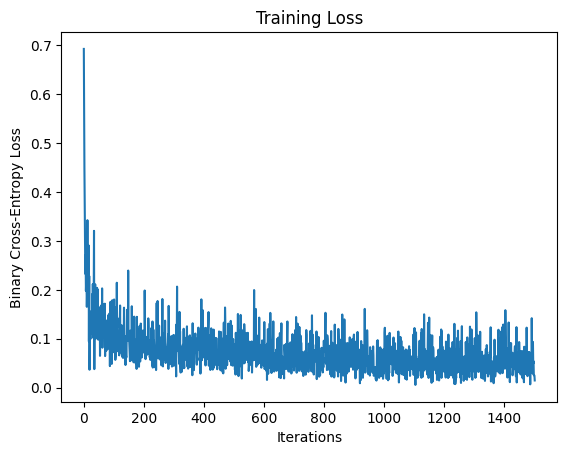

In [22]:
import matplotlib.pyplot as plt
plt.plot(loss_record)
plt.title('Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Binary Cross-Entropy Loss')

## 7. Evaluating the Model

Now that we've trained our model, let's evaluate it on the test set. We'll calculate metrics like precision and recall to see how well it identifies organizations.

In [23]:
# Create a test dataset and loader
testset = Dataset('test.txt', wrd2vec=wrd2vec)
test_loader = DataLoader(testset, batch_size=200, collate_fn=custom_collate_fn)

model.eval()  # Set the model to evaluation mode
model.cpu()

Classifier(
  (layer1): Linear(in_features=1500, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=1, bias=True)
)

In [24]:
batch = next(iter(test_loader))
input_vector, label = batch
prediction = model(input_vector)
loss = get_bce(prediction, label)
loss

tensor(0.0332, grad_fn=<MeanBackward0>)

In [31]:
threshold = 0.3
pred_bool = prediction > threshold
pred_bool.sum()
is_correct = pred_bool.squeeze() == label
is_correct.sum()

accuracy = is_correct.sum() / label.numel() # num_correct_guess / num_entire_problem
accuracy

tensor(0.9750)

In [32]:
# In this kind of unbalanced dataset, we have to calculate precision, recall

# precision = among the predicted result, how many of those are truly positive
# Among the words that are predicted as ORG_name, how many of them are actually ORG_name

predicted_true_and_label_true = pred_bool.squeeze() * label # multiplication  is logicaly AND

precision = predicted_true_and_label_true.sum() / pred_bool.sum()

# recall = among the ground-truth-True samples, how many of those are predicted TRUE
recall = predicted_true_and_label_true.sum() / label.sum()
precision, recall, predicted_true_and_label_true.sum(), pred_bool.sum(), label.sum()

(tensor(0.), tensor(nan), tensor(0.), tensor(5), tensor(0.))

## 8. Using the Model for Inference

Finally, let's use our trained model to predict whether words in a new sentence are organizations.

In [33]:
# Test on a new sentence
model.to(dev)
test_str = "students are studying in library"
test_words = test_str.split(' ')
converted_vector = Dataset.get_flattened_vector(test_words, dataset.wrd2vec)
converted_vector = torch.Tensor(converted_vector)
prediction = model(converted_vector.to(dev))
prediction  # Probability that the center word is an organization

tensor([0.0252], device='cuda:0', grad_fn=<SigmoidBackward0>)

## Conclusion

In this notebook, we've built a Named Entity Recognition system that identifies organizations in text. We:

1. Processed the CoNLL2003 dataset to create context windows for each word
2. Used pre-trained GloVe word embeddings to convert words to vectors
3. Built a simple neural network classifier
4. Trained the model on the training set
5. Evaluated the model on the test set
6. Used the model for inference on new text

This model could be extended to identify other types of entities (people, locations, etc.) by modifying the labels. More advanced NER systems might use architectures like BiLSTMs or Transformers for better performance.